<a href="https://colab.research.google.com/github/DDR7707/End-To-End-DNN-Projects/blob/main/German%20Traffic%20Signs%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of the Traffic sign signals using CNN(Convolution neural networks)
* Importing required dataset from Bitbucket website

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


# Importing required modules for training the model

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
# For importing images from web 
import requests
from PIL import Image

## Loading the bitwise dataset using the pickle module in python to objects

In [4]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
    
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

### Verifing the dataset and counting of the features and labels

In [5]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [7]:
df = pd.read_csv('german-traffic-signs/signnames.csv')
df.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


### Plotting images from the dataset and preprocessing them for better fitting to the model

* Converting to gray scale
* Equalizing for more clarity and feature extraction
* Normalizing all the array values in range of (0 , 1)

(32, 32, 3)
36


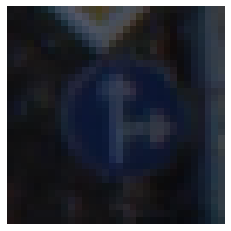

In [8]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


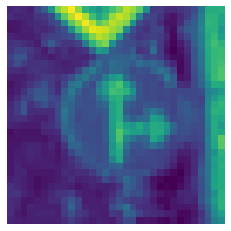

In [9]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)    

(32, 32)


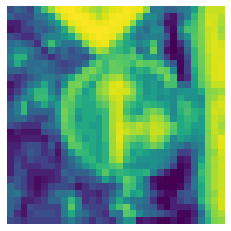

In [10]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [11]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


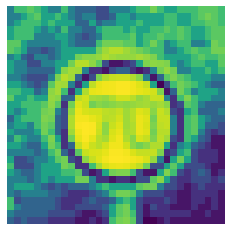

In [12]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

## Reshaping the features for the application of CNN with color channel of 1

In [13]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

## Setting Data Agumentation for better training of model.
* Used to give the insites of various types of same data.
* Refer here for more details : `https://www.geeksforgeeks.org/python-data-augmentation/`

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(20, 32, 32, 1)


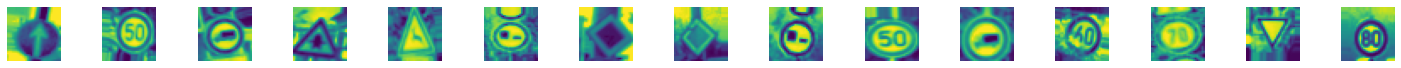

In [15]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

### Converting labels to multiclass arrays with `to_categorical` method from `keras.utils.np_utils` module in keras

In [16]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# Creating a model.
* Adding 2 convolution layer for more feature extraction
* Adding Maxpooling layer
* Adding 2 convolution layer for more feature extraction
* Adding Maxpooling layer
* Finally Flattening to 1 dim array for the input to neural network
* Adding dropout layer to getrid of overfitting of the model (Regularization)
* Applying softmax activation function of final output

In [17]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0

### Fitting the model to the data agumented training data

In [18]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50) , steps_per_epoch = int(34799 / 50) , epochs=15 , validation_data=(X_val, y_val) , shuffle = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
695/695 [==============================] - 16s 19ms/step - loss: 2.5864 - accuracy: 0.2959 - val_loss: 0.2868 - val_accuracy: 0.9082
Epoch 2/15
695/695 [==============================] - 13s 18ms/step - loss: 0.6110 - accuracy: 0.8138 - val_loss: 0.1309 - val_accuracy: 0.9601
Epoch 3/15
695/695 [==============================] - 12s 18ms/step - loss: 0.3443 - accuracy: 0.8953 - val_loss: 0.0931 - val_accuracy: 0.9730
Epoch 4/15
695/695 [==============================] - 12s 18ms/step - loss: 0.2597 - accuracy: 0.9190 - val_loss: 0.0625 - val_accuracy: 0.9789
Epoch 5/15
695/695 [==============================] - 13s 18ms/step - loss: 0.2026 - accuracy: 0.9375 - val_loss: 0.0611 - val_accuracy: 0.9814
Epoch 6/15
695/695 [==============================] - 12s 18ms/step - loss: 0.1703 - accuracy: 0.9476 - val_loss: 0.0602 - val_accuracy: 0.9803
Epoch 7/15
695/695 [==============================] - 13s 18ms/step - loss: 0.1420 - accuracy: 0.9555 - val_loss: 0.0541 - val_accuracy:

## Plotting the accuracy curve on Training vs validation data set

Text(0.5, 0, 'epoch')

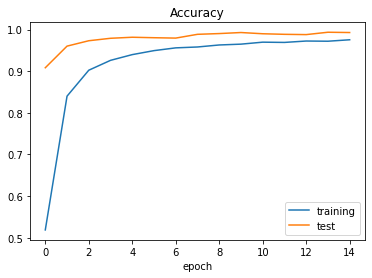

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

# Plotting the loss curve on Training vs validation data set

Text(0.5, 0, 'epoch')

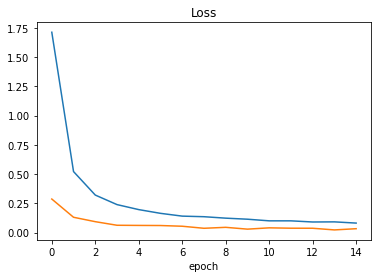

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

## Evaluating our model on the test data

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13058315217494965
Test accuracy: 0.9714964628219604


# Testing our model on the net data from the internet
 * `https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg`  30kmph

 * `https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg`  Left turn

 * `https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg`  Slippery road

 * `https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg`   Yelid

 * `https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg` Bicycles Crossing

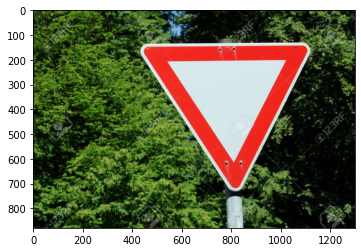

In [39]:
def plotting(url):
    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    return img

image = plotting("https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg")

(32, 32)
predicted sign: [13]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


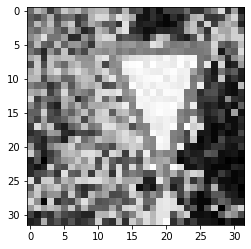

In [41]:
def predicting(img):
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocess(img)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    print(img.shape)
    img = img.reshape(1, 32, 32, 1)
    print("predicted sign: "+ str(model.predict_classes(img)))

predicting(image)

##### Cross check from here....

In [42]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
ClassId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
SignName,Speed limit (20km/h),Speed limit (30km/h),Speed limit (50km/h),Speed limit (60km/h),Speed limit (70km/h),Speed limit (80km/h),End of speed limit (80km/h),Speed limit (100km/h),Speed limit (120km/h),No passing,No passing for vechiles over 3.5 metric tons,Right-of-way at the next intersection,Priority road,Yield,Stop,No vechiles,Vechiles over 3.5 metric tons prohibited,No entry,General caution,Dangerous curve to the left,Dangerous curve to the right,Double curve,Bumpy road,Slippery road,Road narrows on the right,Road work,Traffic signals,Pedestrians,Children crossing,Bicycles crossing,Beware of ice/snow,Wild animals crossing,End of all speed and passing limits,Turn right ahead,Turn left ahead,Ahead only,Go straight or right,Go straight or left,Keep right,Keep left,Roundabout mandatory,End of no passing,End of no passing by vechiles over 3.5 metric ...


# Finally we got a accuracy of 97.1 percent